* Creator: Nirvan S.P. Theethira
* Date: 04/25/2020
* The file is written to implement and test the class `Geoguessr` in the `geoCNN.py` file. The notebook is used to build the `geoCNN` model and train it on loaded data. Test data can also be loaded using the notebook and the model can be tested.
* Note: Run details are specified in each cell. The notebook can be run on drive. The data is available on drive at: https://drive.google.com/drive/folders/1e7RPZEf8-SN9rgsO1oJXE__u04ZEeUXM?usp=sharing

In [1]:
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
from math import sin, cos, sqrt, atan2, radians

# !pip install gmaps
import shapely
import pickle
import random
import numpy as np
import gmaps, os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from ipywidgets.embed import embed_minimal_html
import webbrowser
import geoCNN

# directory containing data
DATADIR = "/home/nirvan/Desktop/github/GeoguessrAI/infoExtraction/data"
# directory to store model in
# MODELDIR = "/home/nirvan/Desktop/github/GeoguessrAI/machineLearning"
MODELDIR = "/home/nirvan/Desktop/models"

# DATADIR = '/content/drive/My Drive/geoguessr'
# MODELDIR = '/content/drive/My Drive/geoguessr'

## Load training and testing data

In [5]:
# load training image file names
TF = np.load(DATADIR+'/trainFiles.npy')
# load testing image file names
TESF = np.load(DATADIR+'/testFiles.npy')
print("Train files: {}, Test files: {}".format(len(TF), len(TESF)))

Train files: 27702, Test files: 1458


243


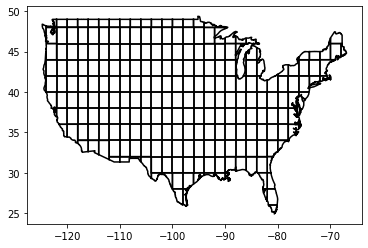

In [7]:
# load split grid file
usaPolyGrid = pickle.load(open("/home/nirvan/Desktop/github/GeoguessrAI/infoExtraction/usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0], color='black')
print(len(usaPolyGrid))

## Create and train model
* Parameters that can be set in the cell below
* `hidden1`: number of neurons for first hidden layer
* `hidden2`: number of neurons for the second hidden layer

In [7]:
# model creation and compilation
geoModel = geoCNN.Geoguessr(hidden1=256,hidden2=256)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 17, 256)        4718848   
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 8, 256)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 4, 8, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)              

In [8]:
# model training
geoModel.fit(trainFiles = TF, 
      dataDir = DATADIR+"/dataCombined/", 
      saveFolder = MODELDIR,
      epochs=100,
      saveEpoch=20,
      batchSize=1000
     )

## Load and test single Model
* Make sure the model file name matches the trained and saved model

In [3]:
modelName = '/model_0.083_6mill.h5'
geoModel = geoCNN.Geoguessr.load(MODELDIR + modelName)

Loading model from /home/nirvan/Desktop/models/model_0.083_6mill.h5
Loaded model accuracy 0.083
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 17, 256)        4718848   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
__________________________

In [8]:
X,y = geoModel.readData(TESF[0:10], DATADIR+"/dataCombined/")

In [13]:
y[0].shape

(243,)

* `fileName`: name of image file to predict grid location
* `actGrid`: Actual gird the image belongs to

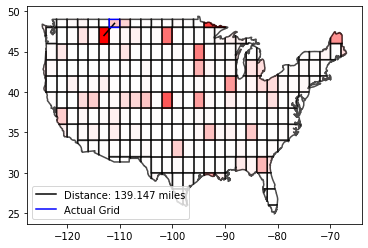

139.14675590860872

In [5]:
fileName = TESF[0]
actGrid = int(fileName.split('+')[0])
geoModel.predictSingle(DATADIR+"/dataCombined/"+fileName, ployGrid=usaPolyGrid, expected=actGrid)

* `fileNames`: List of image file names to predice on
* `actGrids`: List of actual grid location of images

In [6]:
fileNames = TESF[:50]
actGrids = np.array(list(map(lambda x: int(x.split('+')[0]),fileNames)))
geoModel.evaluate([DATADIR+"/dataCombined/"+i for i in fileNames], 
                  actGrids, usaPolyGrid)

Evaluated 0 out of 50 points


971.4706435078465

## Load and test Multiple Models

In [3]:
models = {}
for i in os.listdir(MODELDIR):
    models[i.split('.h5')[0]] = geoCNN.Geoguessr.load(MODELDIR + '/' +i)

Loading model from /home/nirvan/Desktop/models/model_0.025_3mill.h5
Loaded model accuracy 0.025
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 10, 19, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 17, 64)         1179712   
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
__________________________

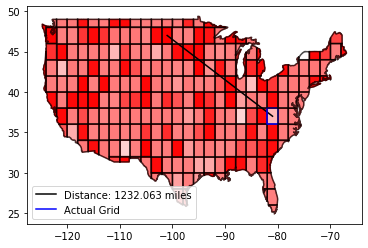

1232.0634610808133

In [22]:
fileName = TESF[20]
models['model_0.071_.h5'].predictSingle(DATADIR+"/dataCombined/"+fileName, ployGrid=usaPolyGrid, expected=int(fileName.split('+')[0]))

In [19]:
models['model_0.071_.h5'].evaluate([DATADIR+"/dataCombined/"+i for i in TESF[:50]], np.array(list(map(lambda x: int(x.split('+')[0]),TESF[:50]))), usaPolyGrid)

Evaluated 0 out of 50 points


750.7130376168556

In [9]:
models

{'model_0.025_3mill.h5': <geoCNN.Geoguessr at 0x7f959451db90>,
 'model_0.039_13mill.h5': <geoCNN.Geoguessr at 0x7f956885c950>,
 'model_0.083_6mill.h5': <geoCNN.Geoguessr at 0x7f9537233ed0>,
 'model_0.071_.h5': <geoCNN.Geoguessr at 0x7f9535c34990>,
 'model_0.001_75th.h5': <geoCNN.Geoguessr at 0x7f953495c910>}